In [4]:
!pip3 install torch 
!pip3 install torchvision
!pip3 install tqdm

    100% |████████████████████████████████| 519.5MB 32kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x591c8000 @  0x7f0d2004f1c4 0x46d6a4 0x5fcbcc 0x4c494d 0x54f3c4 0x553aaf 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54efc1 0x54f24d 0x551ee0 0x54efc1 0x54f24d 0x551ee0 0x54e4c8 0x54f4f6 0x553aaf 0x54e4c8
    100% |████████████████████████████████| 61kB 2.3MB/s 
    100% |████████████████████████████████| 2.0MB 8.9MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0


In [0]:
import os
import gzip
import tarfile
import gc
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms, utils, datasets
from tqdm import tqdm
from torch.nn.parameter import Parameter
import pdb
import matplotlib 
from matplotlib import pyplot as plt
assert torch.cuda.is_available() # You need to request a GPU from Runtime > Change Runtime Type
from IPython.core.ultratb import AutoFormattedTB
__ITB__ = AutoFormattedTB(mode = 'Verbose',color_scheme='LightBg', tb_offset = 1)
 
class CancerDataset(Dataset):
  def __init__(self, root, download=True, size=512, train=True):
    if download and not os.path.exists(os.path.join(root, 'cancer_data')):
      datasets.utils.download_url('http://liftothers.org/cancer_data.tar.gz', root, 'cancer_data.tar.gz', None)
      self.extract_gzip(os.path.join(root, 'cancer_data.tar.gz'))
      self.extract_tar(os.path.join(root, 'cancer_data.tar'))
 
    postfix = 'train' if train else 'test'
    root = os.path.join(root, 'cancer_data', 'cancer_data')
    self.root=root
    self.dataset_folder = torchvision.datasets.ImageFolder(os.path.join(root, 'inputs_' + postfix) ,transform = transforms.Compose([transforms.Resize(size),transforms.ToTensor()]))
    self.label_folder = torchvision.datasets.ImageFolder(os.path.join(root, 'outputs_' + postfix) ,transform = transforms.Compose([transforms.Resize(size),transforms.ToTensor()]))
 
  @staticmethod
  def extract_gzip(gzip_path, remove_finished=False):
    print('Extracting {}'.format(gzip_path))
    with open(gzip_path.replace('.gz', ''), 'wb') as out_f, gzip.GzipFile(gzip_path) as zip_f:
      out_f.write(zip_f.read())
    if remove_finished:
      os.unlink(gzip_path)
 
  @staticmethod
  def extract_tar(tar_path):
    print('Untarring {}'.format(tar_path))
    z = tarfile.TarFile(tar_path)
    z.extractall(tar_path.replace('.tar', ''))
 
 
  def __getitem__(self,index):
    img = self.dataset_folder[index]
    label = self.label_folder[index]
    return img[0],label[0][0]
  
 
  def __len__(self):
    return len(self.dataset_folder)
  
class CancerDetection(nn.Module):
  def __init__(self):
    super(CancerDetection, self).__init__()
 
    self.conv1 = nn.Conv2d(3,64,kernel_size = 3, stride = 1, padding = 1)
    self.conv2 = nn.Conv2d(64,64,kernel_size = 3, stride = 1, padding = 1)
    self.bn1 = nn.BatchNorm2d(64)
    self.maxpool1 = nn.MaxPool2d(2)
    
    self.conv3 = nn.Conv2d(64,128,kernel_size = 3, stride = 1, padding = 1)
    self.conv4 = nn.Conv2d(128,128,kernel_size = 3, stride = 1, padding = 1)    
    self.bn2 = nn.BatchNorm2d(128)
    self.maxpool2 = nn.MaxPool2d(2)

    self.conv5 = nn.Conv2d(128,256,kernel_size = 3, stride = 1, padding = 1)
    self.conv6 = nn.Conv2d(256,256,kernel_size = 3, stride = 1, padding = 1)    
    self.bn3 = nn.BatchNorm2d(256)
    self.maxpool3 = nn.MaxPool2d(2)
    
    self.conv7 = nn.Conv2d(256,512,kernel_size = 3, stride = 1, padding = 1)
    self.conv8 = nn.Conv2d(512,512,kernel_size = 3, stride = 1, padding = 1)    
    self.bn4 = nn.BatchNorm2d(512)
    self.maxpool4 = nn.MaxPool2d(2)
    
    self.conv9 = nn.Conv2d(512,1024,kernel_size = 3, stride = 1, padding = 1)
    self.conv10 = nn.Conv2d(1024,1024,kernel_size = 3, stride = 1, padding = 1)    
    self.bn5 = nn.BatchNorm2d(1024)
    
    self.upcon1 =  nn.ConvTranspose2d(1024,512, stride=2, kernel_size=2)
    
    self.conv11=nn.Conv2d(1024,512,kernel_size = 3, stride = 1, padding = 1)
    self.conv12=nn.Conv2d(512,512,kernel_size = 3, stride = 1, padding = 1)
    self.bn6 = nn.BatchNorm2d(512)
    self.upcon2 =  nn.ConvTranspose2d(512,256, stride=2, kernel_size=2)
    
    self.conv13=nn.Conv2d(512,256,kernel_size = 3, stride = 1, padding = 1)
    self.conv14=nn.Conv2d(256,256,kernel_size = 3, stride = 1, padding = 1)
    self.bn7 = nn.BatchNorm2d(256)
    self.upcon3 =  nn.ConvTranspose2d(256,128, stride=2, kernel_size=2)

    self.conv15=nn.Conv2d(256,128,kernel_size = 3, stride = 1, padding = 1)
    self.conv16=nn.Conv2d(128,128,kernel_size = 3, stride = 1, padding = 1)
    self.bn8 = nn.BatchNorm2d(128)
    self.upcon4 =  nn.ConvTranspose2d(128,64, stride=2, kernel_size=2)
    
    self.conv17=nn.Conv2d(128,64,kernel_size = 3, stride = 1, padding = 1)
    self.conv18=nn.Conv2d(64,64,kernel_size = 3, stride = 1, padding = 0)
    self.bn9 = nn.BatchNorm2d(64)
    
    
    self.convLast= nn.Conv2d(64,2, kernel_size=1, stride=1, padding=1)
 
  def forward(self, input):
    conv1_out = F.relu(self.conv1(input))
    conv2_out = F.relu(self.conv2(conv1_out))
    bn1_out = self.bn1(conv2_out)
    maxPool1_out = self.maxpool1(bn1_out)
    
    
    conv3_out = F.relu(self.conv3(maxPool1_out))
    conv4_out = F.relu(self.conv4(conv3_out))
    bn2_out = self.bn2(conv4_out)
    maxPool2_out = self.maxpool2(bn2_out)

    conv5_out = F.relu(self.conv5(maxPool2_out))
    conv6_out = F.relu(self.conv6(conv5_out))
    bn3_out = self.bn3(conv6_out)
    maxPool3_out = self.maxpool3(bn3_out)    
    
    conv7_out = F.relu(self.conv7(maxPool3_out))
    conv8_out = F.relu(self.conv8(conv7_out))
    bn4_out = self.bn4(conv8_out)
    maxPool4_out = self.maxpool4(bn4_out) 
        
    conv9_out = F.relu(self.conv9(maxPool4_out))
    conv10_out = F.relu(self.conv10(conv9_out))
    bn5_out = self.bn5(conv10_out)
    upcon1_out=self.upcon1(bn5_out)
    
    concat1 = torch.cat((bn4_out, upcon1_out), 1)
    conv11_out = F.relu(self.conv11(concat1))
    conv12_out = F.relu(self.conv12(conv11_out))
    bn6_out = self.bn6(conv12_out)
    upcon2_out = self.upcon2(bn6_out)
    
    concat2 = torch.cat((bn3_out, upcon2_out), 1)
    conv13_out = F.relu(self.conv13(concat2))
    conv14_out = F.relu(self.conv14(conv13_out))
    bn7_out = self.bn7(conv14_out)
    upcon3_out = self.upcon3(bn7_out)
    
    concat3 = torch.cat((bn2_out, upcon3_out), 1)
    conv15_out = F.relu(self.conv15(concat3))
    conv16_out = F.relu(self.conv16(conv15_out))
    bn8_out = self.bn8(conv16_out)
    upcon4_out = self.upcon4(bn8_out)
    
    concat4 = torch.cat((bn1_out, upcon4_out), 1)
    conv17_out = F.relu(self.conv17(concat4))
    conv18_out = F.relu(self.conv18(conv17_out))
    bn9_out = self.bn9(conv18_out)  
    

    last = self.convLast(bn9_out)
    return last

In [2]:
def scope():
  try:
    train_dataset= CancerDataset(root='/tmp/cancer', train=True)
    #pdb.set_trace()
    
    val_dataset= CancerDataset(root='/tmp/cancer', train=False) 

    #plt.imshow(train_dataset[1005][0].permute(1,2,0))
    #plt.show()
    #label=train_dataset[1005][1]
    #pdb.set_trace()
    #print(label.size())
    #plt.imshow(label)

    #model= ConvNetwork(train_dataset)
    #model = model.cuda()
    #pdb.set_trace()
    #objective = CrossEntropyLoss()
    #optimizer = optim.Adam(model.parameters(), lr = 1e-4)
    train_loader = DataLoader(train_dataset, batch_size=2, pin_memory=True, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=2, pin_memory=True, shuffle=True)
    model= CancerDetection()
    model.cuda()
    objective = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr = 1e-4)

    gc.collect()
    #print(torch.cuda.memory_allocated(0) / 1e9)
    losses=[]
    val_loss=[]
    val_acc=[]
    xs=[]
 
    for epoch in range(8):
      loop =tqdm(total=len(train_loader), position=0, leave=False)
      #pdb.set_trace()
      for batch, (x, y_truth) in enumerate(train_loader):
        #pdb.set_trace()
        y_truth =y_truth.type(torch.LongTensor)
        x, y_truth = x.cuda(async=True), y_truth.cuda(async=True)
        optimizer.zero_grad()
        #pdb.set_trace()
        y_hat=model(x)
        #pdb.set_trace()
        loss = objective(y_hat, y_truth)
        loss.backward()
        losses.append(loss.item())
        loop.set_description('epoch:{}, loss:{:.4f}, batch:{}'.format(epoch, loss.item(), batch)) 
        loop.update(1)

        optimizer.step()
        

        if batch%200 == 0:
          all_batches_loss= []
          all_batches_acc=[]
          validationLoop=tqdm(total=len(val_loader), position=0, leave=False)
          for val_batch, (x, y_truth) in enumerate(val_loader):
            loop.set_description('batch:{}'.format(val_batch))
            loop.update(1)
            #print(y_truth.size())
            y_truth =y_truth.type(torch.LongTensor)
            x, y_truth = x.cuda(async=True), y_truth.cuda(async=True)
            y_hat=model(x.cuda())
            loss = objective(y_hat, y_truth)
            y_hat=y_hat.argmax(1)
            correct = y_truth.eq(y_hat).float().mean()
            all_batches_acc.append(correct)
            all_batches_loss.append(loss.item())
          val_loss.append(np.mean(all_batches_loss))
          val_acc.append(np.mean(all_batches_acc))
          xs.append(batch+epoch*len(train_loader))

    
    image72 = val_dataset[172]
    y_hat72 = model(image72[0].unsqueeze(0).cuda())
    return losses, val_loss, image72, y_hat72, xs, val_acc
        
  except:
    __ITB__()
    gc.collect()
 
losses, val_losses, image72, y_hat72, xs, val_acc=scope()

epoch:7, loss:0.1470, batch:670: : 1023it [25:23,  1.87s/it]

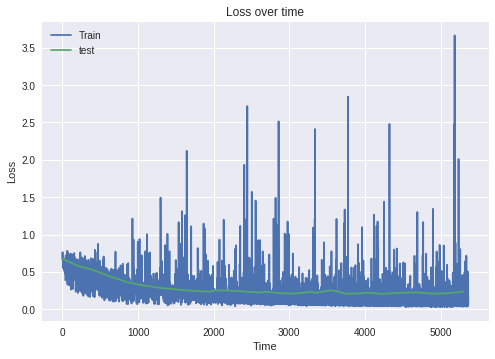

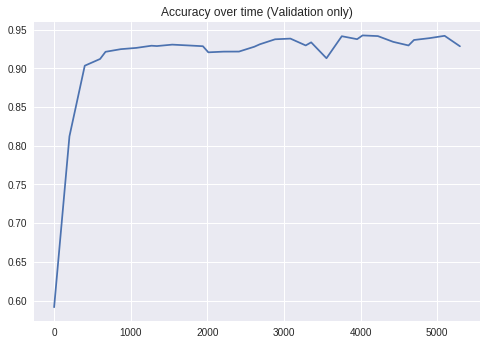

In [3]:
#val_losses=[1,2,3]
#losses = [3,2,1]
plt.plot(losses, label="Train")
plt.plot(xs, val_losses, label="test")
plt.title("Loss over time")
plt.ylabel("Loss")
plt.xlabel("Time")
plt.legend()
plt.show()
plt.plot(xs, val_acc)
plt.title("Accuracy over time (Validation only)")
plt.show()

Image of the cell


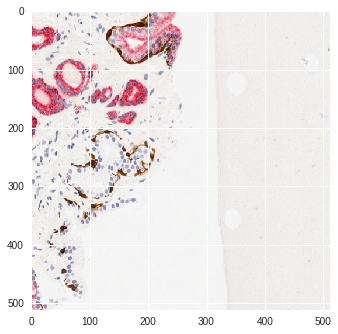

Truth (cancer in black)


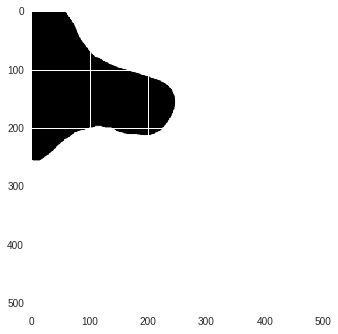

My prediction (cancer in black)


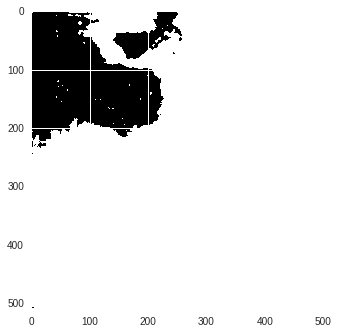

In [4]:
print("Image of the cell")
plt.imshow(image72[0].permute(1,2,0))
plt.show()
label=image72[1]
    #pdb.set_trace()
    #print(label.size())
print("Truth (cancer in black)")
plt.imshow(label)
plt.show()
prediction=torch.argmax(y_hat72, 1).squeeze(0)
print("My prediction (cancer in black)")
plt.imshow(prediction)
plt.show()

NameError: ignored